In [72]:
from denoisers.NLM import *
from PIL import *
from iterative_algorithms import *
from forward_models import *
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import scipy.ndimage

import pandas as pd

from scipy.ndimage import zoom

plt.rcParams['figure.figsize'] = (2,2)  # Width, Height in inches



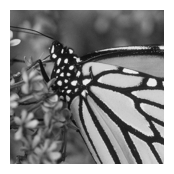

In [73]:
#read the image
image = Image.open("./images/5.png")
#convert the image to a numpy array
image = np.array(image)
#to double
image = image.astype(np.float64)
#to range 0 to 1P_operator
image = image/255.0


plt.imshow(image, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

In [74]:
A_function = superresolution
A_kwargs = {'f_blur':gaussian_blurring,'blur_kwargs':{'radius':12,'sigma':1.6},'downsample_fraction_x':1/2,'downsample_fraction_y':1/2}
A_function_adjoint = superresolution_adjoint
A_adjoint_kwargs = {'f_blur':gaussian_blurring,'blur_kwargs':{'radius':12,'sigma':1.6},'original_image_rows':image.shape[0],'original_image_cols':image.shape[1],'downsample_fraction_x':1/2,'downsample_fraction_y':1/2}



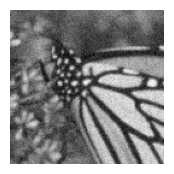

In [ ]:
# b0 = A_function(image, **A_kwargs)
b0 = A_function(image, **A_kwargs) 

np.random.seed(7)
b0 = b0 + np.random.normal(0, 0.04, b0.shape)
input_image = b0.copy()




plt.imshow(b0, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

In [76]:
#FISTA
def fista(input_image,start_image,denoiser,denoiser_kwargs,eta = 0.9,num_iter=1000):
    x_old = start_image.copy()
    y = start_image.copy()
    # N = [calc_cost(x_old,input_image)]
    N = []
    all_iters = []
    t=1

    for i in range(num_iter):
        x = P_operator(y,denoiser=DSG_NLM,denoiser_kwargs=denoiser_kwargs,A_function=A_function,
                       A_kwargs=A_kwargs,A_function_adjoint=A_function_adjoint,
                       A_adjoint_kwargs=A_adjoint_kwargs,eta=eta) + eta*denoiser(A_function_adjoint(input_image,
                                                                                            **A_adjoint_kwargs),**denoiser_kwargs)
        t_new = 0.5*(1+np.sqrt(1+4*t**2))
        alpha = (t-1)/t_new
        # alpha = 1 - 1/np.log(i+2)
        # alpha=0.0
        y = x + alpha*(x-x_old)
      
        all_iters.append(x_old)
        x_old = x
        t = t_new
       

    return x,N,all_iters




In [77]:


def generate_guide_image(input_image,original_image):
    print("Generating guide image")
    #First bicubic interpolation
    gmm = scipy.ndimage.zoom(input_image, 2, order=3)
    possible_sigma = [20] ## use more combinations for better results
    possible_window = [3]
    possible_patch = [1]

 
    best_ssim = 0
    

    for sig in possible_sigma:
        for win in possible_window:
            for pat in possible_patch:
                if pat > win:
                    continue

                dn = {}
                dn["patch_rad"] = pat
                dn["window_rad"] = win
                dn["sigma"] = sig/255.0
                dn["guide_image"] = gmm.copy()
                start_image = gmm.copy()
                for i in range(30):
                    # print(i)
                    a,_,_ = fista(input_image,start_image,DSG_NLM,dn,eta=0.9,num_iter=1)
                    # print("--intermediate--ssim:",ssim(a,original_image, data_range=1.0))
                    # print("-------------")
                    dn["guide_image"] = a.copy()
                    start_image = a.copy()
                        
                ssim_index = ssim(a, original_image, data_range=1.0)
                print("sigma:",sig,"window:",win,"patch:",pat,"SSIM:",ssim_index)
                if ssim_index > best_ssim:
                    best_ssim = ssim_index
                    best_sigma = sig
                    best_window = win
                    best_patch = pat
                    best_gm = a.copy()
    
    print("Best SSIM:", best_ssim)
    print("Best sigma:", best_sigma)
    print("Best window:", best_window)
    print("Best patch:", best_patch)
    print("Guide image generated")
    return best_gm,best_ssim

In [ ]:


def reconstruction(input_image,original_image,guide_image_status=True,guide_image=None):
    if not guide_image_status:
        gm, best_ssim_gm = generate_guide_image(input_image,original_image)
    
    else:
        if guide_image is not None:
            gm = guide_image.copy()
        else:
            print("Using original image as guide image")
            gm = original_image.copy()


    possible_sigma = [30] #### use different combinations for possible better results but it will take more time
    possible_window = [5]
    possible_patch = [1]
    
    
    
    
   
    best_ssim = 0

    for sig in possible_sigma:
        for win in possible_window:
            for pat in possible_patch:
                if pat > win:
                    continue

                dn = {}
                dn["patch_rad"] = pat
                dn["window_rad"] = win
                dn["sigma"] = sig/255.0
                dn["guide_image"] = gm.copy()
                start_image = np.zeros_like(original_image)

                xx,_,all_iters = fista(input_image,start_image,DSG_NLM,dn,eta=0.9,num_iter=30)


                all_psnrs = [psnr(x,original_image, data_range=1.0) for x in all_iters]
                plt.plot(all_psnrs)
                plt.xlabel("Iterations")
                plt.ylabel("PSNR")
                plt.show()
                plt.close()



                ssim_index = ssim(xx, original_image, data_range=1.0)
                psnr_value = psnr(xx, original_image, data_range=1.0)
                print("sigma:",sig,"window:",win,"patch:",pat,"SSIM:",ssim_index)
                if ssim_index > best_ssim:
                    best_ssim = ssim_index
                    best_ps = psnr_value
                    best_sigma = sig
                    best_window = win
                    best_patch = pat
                    best_xx = xx.copy()
    


    print("Best SSIM:", best_ssim)
    print("Best sigma:", best_sigma)
    print("Best window:", best_window)
    print("Best patch:", best_patch)

    #plot the reconstructions



    print("Reconstruction Completed.")
    return best_xx,gm,best_ssim,best_ps,best_sigma,best_window,best_patch
 

Generating guide image
sigma: 20 window: 3 patch: 1 SSIM: 0.8080650237938624
Best SSIM: 0.8080650237938624
Best sigma: 20
Best window: 3
Best patch: 1
Guide image generated


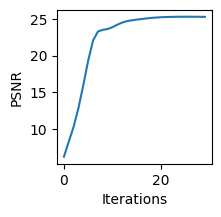

sigma: 30 window: 5 patch: 1 SSIM: 0.8206186644640235
Best SSIM: 0.8206186644640235
Best sigma: 30
Best window: 5
Best patch: 1
Reconstruction Completed.


True

In [80]:
exp_results1 = reconstruction(input_image,image,guide_image_status=False)
reconstruction = exp_results1[0]
guide_image = exp_results1[1]
cv2.imwrite("reconstruction.png",reconstruction*255)

<Figure size 1600x400 with 0 Axes>

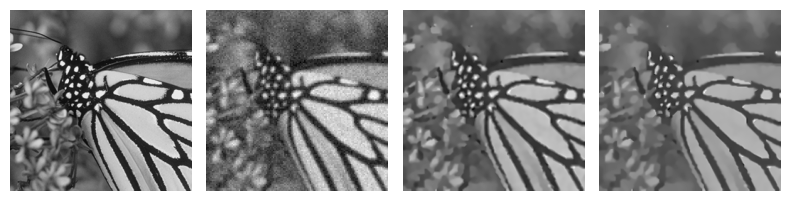

In [81]:


plt.figure(figsize=(16,4))  # Width, Height in inches

fig, axes = plt.subplots(1,4,figsize = (8,8))

# Plot original image
axes[0].imshow(image, cmap='gray')
# axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axis

# Plot input image
axes[1].imshow(input_image, cmap='gray')
# axes[1].set_title('Input Image')
axes[1].axis('off')  # Hide axis

# Plot guide image
axes[2].imshow(guide_image, cmap='gray')
# axes[2].set_title('Guide Image')
axes[2].axis('off')  # Hide axis

# Plot reconstructed image
axes[3].imshow(reconstruction, cmap='gray')
# axes[3].set_title('Reconstructed Image')
axes[3].axis('off')  # Hide axis

# Show the plot
plt.tight_layout()
plt.show()